In [19]:
import pandas as pd
import random
from gensim.models import Word2Vec
from scipy.spatial.distance import cosine
from scipy.stats import ttest_ind
import seaborn as sns
import matplotlib.pyplot as plt



In [2]:
df_train = pd.read_csv("RB198.csv")


In [3]:
# Function to alter a certain percentage of residues in a sequence
def alter_sequence(sequence, alter_percent):
    sequence = list(sequence)
    num_to_alter = int(len(sequence) * alter_percent / 100)
    positions = random.sample(range(len(sequence)), num_to_alter)
    for pos in positions:
        sequence[pos] = random.choice('ACDEFGHIKLMNPQRSTVWY')  # 20 standard amino acids
    return ''.join(sequence)

def cosine_similarity(vec1, vec2):
    return 1 - cosine(vec1, vec2)

In [4]:
original_sequences = df_train['Sequence'].tolist()

# Generate datasets with altered sequences
alter_percentages = [40, 45, 50, 55]
altered_datasets = {percent: [] for percent in alter_percentages}

for seq in original_sequences:
    for percent in alter_percentages:
        altered_seq = alter_sequence(seq, percent)
        altered_datasets[percent].append(altered_seq)


In [7]:
# Train Word2Vec models on each altered dataset
word2vec_models = {}
for percent, sequences in altered_datasets.items():
    # Tokenize sequences for Word2Vec (simple tokenization by splitting each residue as a token)
    tokenized_sequences = [[residue for residue in seq] for seq in sequences]
    model = Word2Vec(sentences=tokenized_sequences, vector_size=25, window=5, min_count=1, workers=1 , epochs=200, sg=0, negative=5)
    word2vec_models[percent] = model


In [ ]:
import numpy as np

amino_acids = word2vec_models[40].wv.index_to_key
semantic_relationships = {percent: {} for percent in alter_percentages}

for percent, model in word2vec_models.items():
    for aa1 in amino_acids:
        for aa2 in amino_acids:
            if aa1 != aa2:
                vec1 = model.wv[aa1]
                vec2 = model.wv[aa2]
                similarity = cosine_similarity(vec1, vec2)
                if aa1 not in semantic_relationships[percent]:
                    semantic_relationships[percent][aa1] = []
                semantic_relationships[percent][aa1].append(similarity)

p_value_matrix = pd.DataFrame(index=amino_acids, columns=amino_acids)

# Perform pairwise t-tests and fill the p-value matrix
for aa1 in amino_acids:
    for aa2 in amino_acids:
        if aa1 != aa2:
            similarities_aa1 = [semantic_relationships[percent][aa1] for percent in alter_percentages]
            similarities_aa2 = [semantic_relationships[percent][aa2] for percent in alter_percentages]
            t_stat, p_val = ttest_ind(similarities_aa1, similarities_aa2)
            p_value_matrix.at[aa1, aa2] = np.average(p_val)
        else:
            p_value_matrix.at[aa1, aa2] = 1  # Self-comparison is not needed



In [47]:
p_value_matrix

,L,E,A,V,K,R,G,I,D,S,T,P,F,Q,N,Y,H,M,W,C
L,1,0.358516,0.489396,0.438024,0.571166,0.382873,0.42634,0.472805,0.488315,0.467044,0.433754,0.448539,0.42481,0.50293,0.414336,0.556169,0.516838,0.516488,0.603085,0.581374
E,0.358516,1,0.36226,0.358213,0.357356,0.467451,0.213571,0.284627,0.181662,0.176171,0.177573,0.156391,0.151423,0.247047,0.182776,0.279763,0.239668,0.266956,0.282818,0.240928
A,0.489396,0.36226,1,0.686614,0.488474,0.418287,0.359287,0.468997,0.390619,0.403698,0.416699,0.432234,0.393321,0.546067,0.461902,0.497467,0.456986,0.374331,0.562069,0.451392
V,0.438024,0.358213,0.686614,1,0.450533,0.5253,0.388275,0.451888,0.388071,0.401611,0.355068,0.395851,0.344006,0.471352,0.40454,0.447657,0.454337,0.293562,0.418318,0.406703
K,0.571166,0.357356,0.488474,0.450533,1,0.346926,0.27624,0.454199,0.286862,0.33559,0.269351,0.324281,0.312725,0.385024,0.314626,0.377968,0.521225,0.34473,0.45078,0.360359
R,0.382873,0.467451,0.418287,0.5253,0.346926,1,0.337452,0.227315,0.26224,0.246771,0.240293,0.299467,0.188448,0.378527,0.198823,0.244051,0.322443,0.154704,0.225456,0.310332
G,0.42634,0.213571,0.359287,0.388275,0.27624,0.337452,1,0.320258,0.342398,0.283113,0.314232,0.433682,0.33526,0.399931,0.391594,0.451791,0.338396,0.372848,0.381935,0.437911
I,0.472805,0.284627,0.468997,0.451888,0.454199,0.227315,0.320258,1,0.433734,0.47648,0.52168,0.402624,0.527008,0.380446,0.448222,0.534396,0.369129,0.490382,0.527613,0.413315
D,0.488315,0.181662,0.390619,0.388071,0.286862,0.26224,0.342398,0.433734,1,0.520455,0.549414,0.479026,0.50824,0.421208,0.413024,0.547493,0.360296,0.581807,0.452207,0.42458
S,0.467044,0.176171,0.403698,0.401611,0.33559,0.246771,0.283113,0.47648,0.520455,1,0.537683,0.358812,0.439229,0.407601,0.507505,0.543883,0.509893,0.414364,0.462064,0.476645


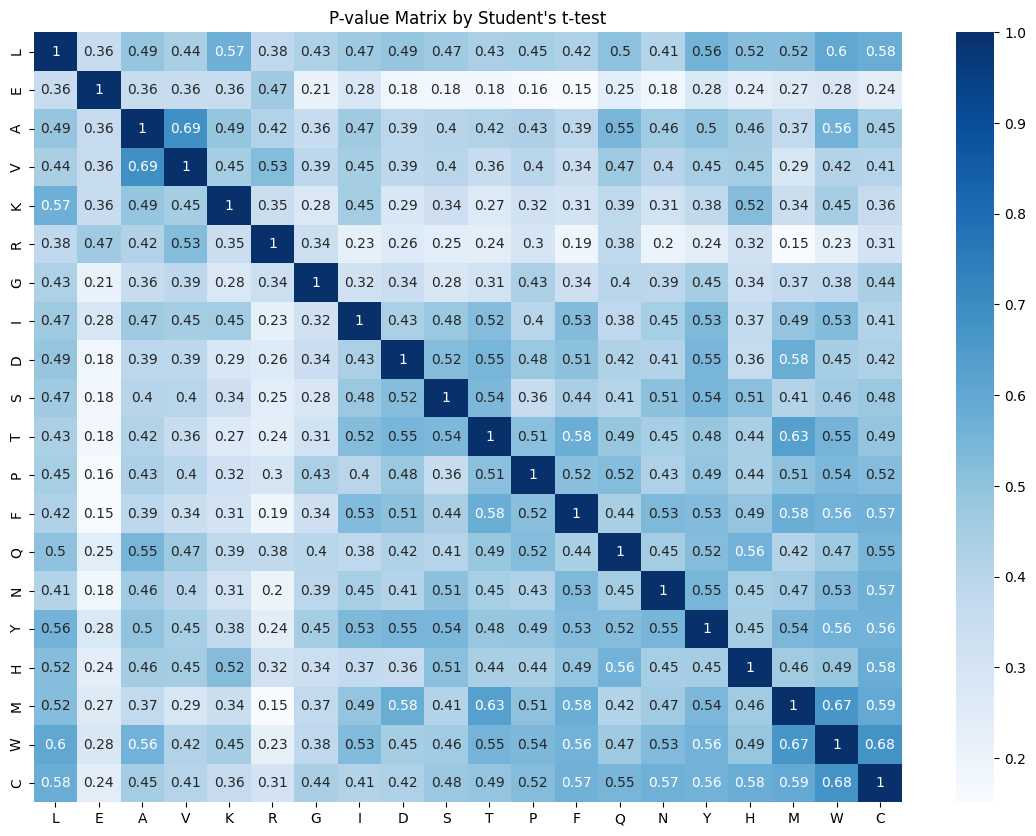

In [50]:
# Convert the p-value matrix to float
p_value_matrix = p_value_matrix.astype(float)

# Plot the heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(p_value_matrix, annot=True, cmap="Blues", cbar=True)
plt.title("P-value Matrix by Student's t-test")
plt.show()